# Séries Temporais - Redes Neurais

## Importar bibliotecas
[Numpy](https://numpy.org/)<br>
[PyPlot](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.html)<br>

[Tensorflow](https://www.tensorflow.org/api_docs/python/tf)
* API [tf.data API](https://www.tensorflow.org/guide/data)
* Classe [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from matplotlib.pylab import rcParams
# tamanho das imagens
rcParams['figure.figsize'] = 16, 8

## Conectar com Google Drive

In [ ]:
# Conectar com o Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

## Funções

### Plotar séries temporais

In [2]:
def plotar_series(tempo, series, format="-", inicio=0, fim=None):

    # Dimensões da figura
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:
        for series_num in series:
            # Plotar valores x tempo
            plt.plot(tempo[inicio:fim], series_num[inicio:fim], format)
    else:
        # Plotar valores x tempo
        plt.plot(tempo[inicio:fim], series[inicio:fim], format)

    # Rótulo do eixo x
    plt.xlabel("Tempo")

    # Rótulo do eixo y
    plt.ylabel("Valor")

    # Plotar grid
    plt.grid(True)

    # Mostrar a gráfico
    plt.show()

### Cálcular de métricas de acuidade de previsão

In [3]:
# Métricas de acuidade de previsão
def metricas(previsto, observado):
    erro = previsto - observado                   # erro
    me = np.mean(erro)                            # ME
    mse = np.square(erro).mean()                  # MSE
    rmse = np.sqrt(mse)                           # RMSE
    mae = np.abs(erro).mean()                     # MAE
    mpe = (erro / observado).mean()               # MPE
    mape = np.abs(erro / observado).mean()        # MAPE
    mins = np.amin(np.hstack([previsto[:,None],
                              observado[:,None]]), axis=1)
    maxs = np.amax(np.hstack([previsto[:,None],
                              observado[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)               # MINMAX
    return({'ME':me, 'MSE':mse, 'RMSE':rmse,
            'MAE': mae, 'MPE': mpe, 'MAPE':mape,
            'MIN-MAX':minmax})

In [4]:
def janelamento_lotes(serie, tam_janela, tam_lote, buffer_embaralhamento):
     # Cria um dataset TF Dataset a partir dos valores da serie
    dataset = tf.data.Dataset.from_tensor_slices(serie)

    # Janelamento dos dados
    dataset = dataset.window(tam_janela + 1, shift=1, drop_remainder=True)

    # Ajustar as janelas (flatten) colocando seus elementos em lotes
    dataset = dataset.flat_map(lambda window: window.batch(tam_janela + 1))

    # Criar tuplas com variáveis (features) e rótulos (labels)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Embaralhar janelas
    dataset = dataset.shuffle(buffer_embaralhamento)

    # Criar lotes de treinamento
    dataset = dataset.batch(tam_lote).prefetch(1)

    return dataset

### Carregar dados
Dados de requisição diária aos servidores.

In [5]:
# Carregar dados
serie_requisicoes_dia = pd.read_csv(
    '/content/servidores_requisicoes_dia.csv', index_col=0, parse_dates=True)
serie_requisicoes_dia.head(3)

,WEB,BD,APLIC
Data,,,
2006-01-01,1069.184,NaN,NaN
2006-01-02,1380.521,NaN,NaN
2006-01-03,1442.533,NaN,NaN


# Série de requisições mensais ao servidor WEB

In [6]:
# Seleciona coluna WEB e reformata para requisições mensais (soma)
mensal = serie_requisicoes_dia['WEB'].resample('M').sum()
serie_WEB = pd.DataFrame(mensal.values, mensal.index, columns=['Valor'])
tam_serie_WEB = serie_WEB.shape[0]
serie_WEB.head(10)

<ipython-input-6-ec03a8a48a9f>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  mensal = serie_requisicoes_dia['WEB'].resample('M').sum()


,Valor
Data,
2006-01-31,45304.704
2006-02-28,41078.993
2006-03-31,43978.124
2006-04-30,38251.767
2006-05-31,38858.143
2006-06-30,37253.450
2006-07-31,38852.185
2006-08-31,38476.852
2006-09-30,39335.098


## Criar o dataset

In [7]:
# Criar o dataset
serie_WEB_RN = serie_WEB['Valor'].values
print(type(serie_WEB_RN))
print(len(serie_WEB_RN))
tempo_WEB_RN = np.arange(len(serie_WEB_RN), dtype="float32")
print(type(tempo_WEB_RN))
print(len(tempo_WEB_RN))

<class 'numpy.ndarray'>
144
<class 'numpy.ndarray'>
144


## Dividir os dados
* Dividir os dados em conjunto de treinamento e conjunto de validação
* Primeiros 2/3 dos pontos para treinamento e o restante é para validação

In [8]:
# Definir o tamanho do conjunto de treinamento
tam_trein_WEB_RN = int(2/3*len(serie_WEB_RN))

# Conjunto de treinamento
tempo_trein_WEB_RN = tempo_WEB_RN[:tam_trein_WEB_RN]
x_trein_WEB_RN = serie_WEB_RN[:tam_trein_WEB_RN]

# Conjunto de validação
tempo_valid_WEB_RN = tempo_WEB_RN[tam_trein_WEB_RN:]
x_valid_WEB_RN = serie_WEB_RN[tam_trein_WEB_RN:]

## Plotar série de treinamento

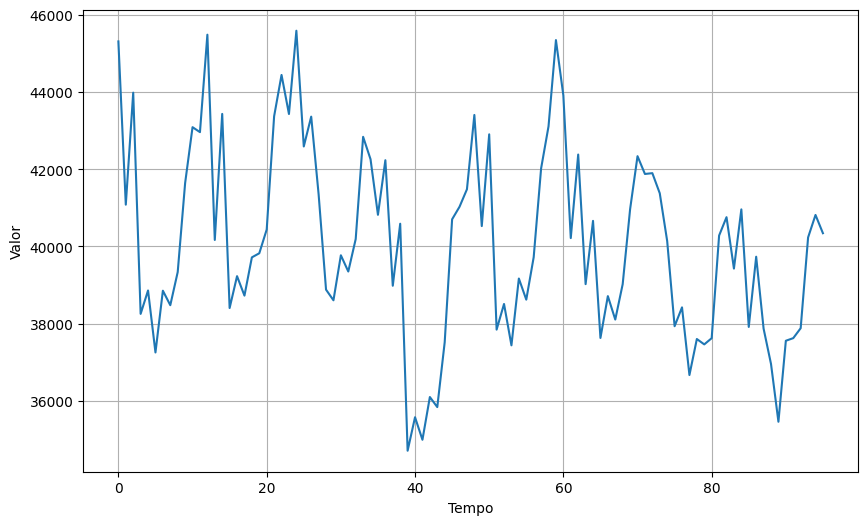

In [9]:
# Plotar série de treinamento
plotar_series(tempo_trein_WEB_RN, x_trein_WEB_RN)

## Plotar série de validação

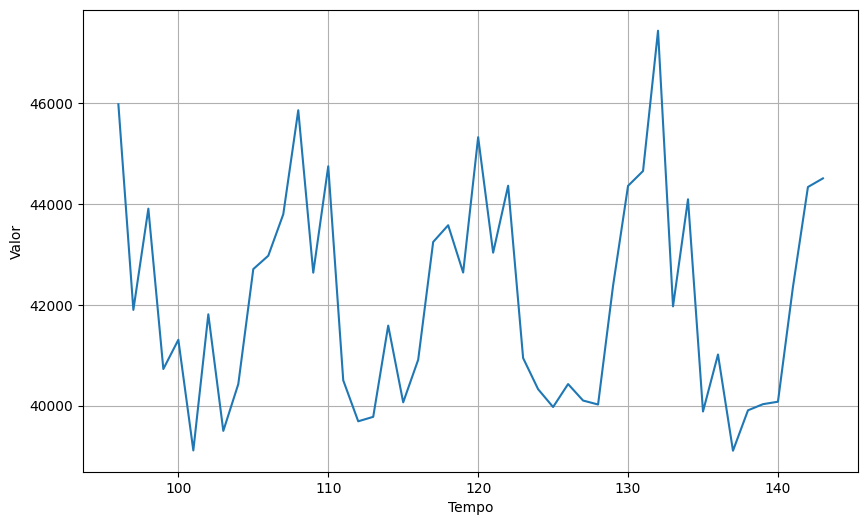

In [10]:
# Plotar série de validação
plotar_series(tempo_valid_WEB_RN, x_valid_WEB_RN)

# Modelo - WEB RN
### Rede neural sequencial com 1 camada densa

## Preparar dataset para treinamento

### Parâmetros

In [11]:
# Parameteros
tam_janela_WEB_RN = 7
tam_lote_WEB_RN = 128
tam_buffer_embaralhamento_WEB_RN = 10

### Criar dataset de treinamento

In [12]:
# Criar dataset de treinamento
dataset_WEB_RN = janelamento_lotes(
    x_trein_WEB_RN, tam_janela_WEB_RN, tam_lote_WEB_RN, tam_buffer_embaralhamento_WEB_RN)

## Construir o modelo

In [13]:
# Construir o modelo
# Rede neural sequencial com 1 camada densa
c0 = tf.keras.layers.Dense(1, input_shape=[tam_janela_WEB_RN])
modelo_WEB_RN = tf.keras.models.Sequential([c0])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compilar o modelo
Prâmetros de treinamento:
* Função de perda (loss function): [*mean squared error (mse)*](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError).
* Algoritmo de otimização:  [*Adam algorithm*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam).

In [14]:
# Compilar o modelo
modelo_WEB_RN.compile(loss="mse", optimizer=tf.keras.optimizers.Adam())

### Treinar o modelo

In [15]:
# Treinar o modelo
resultado_treinamento_WEB_RN = modelo_WEB_RN.fit(dataset_WEB_RN,epochs=400, verbose = 0);

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


### Plotar perda em função da taxa de aprendizagem

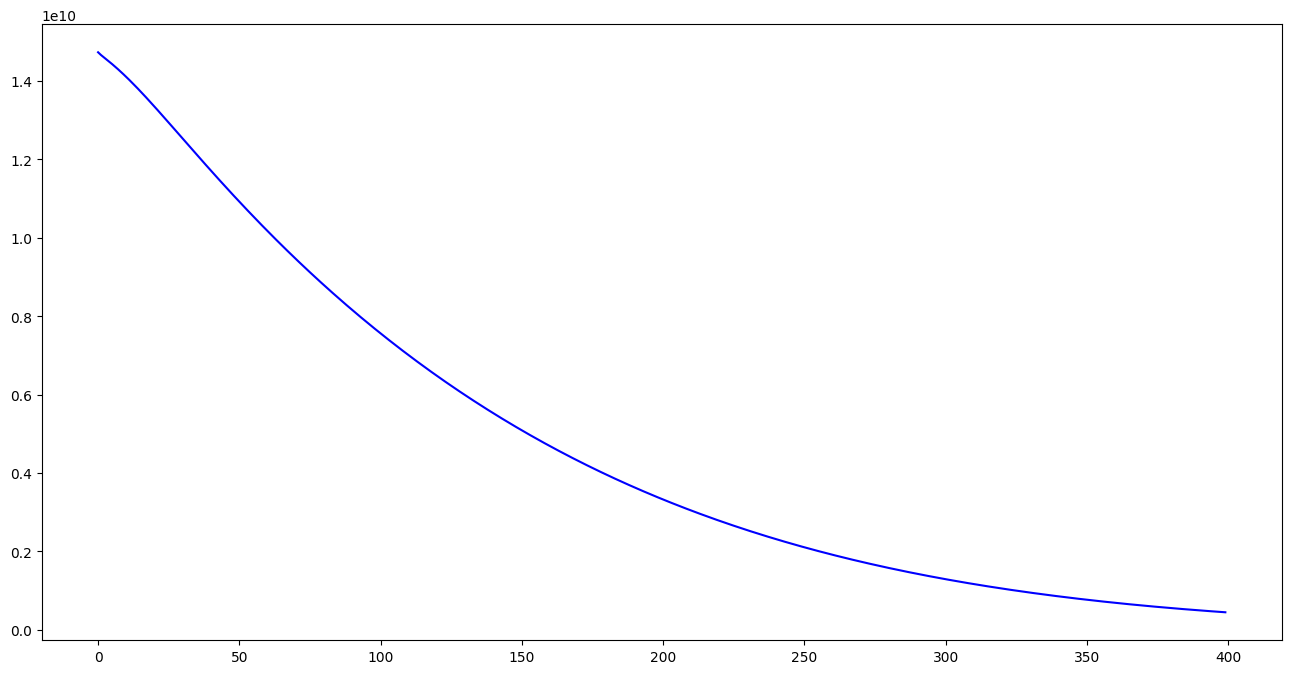

In [16]:
# Plotar perda em função da taxa de aprendizagem
perdas_WEB_RN = resultado_treinamento_WEB_RN.history['loss']
epocas_WEB_RN = range(len(perdas_WEB_RN))
plt.plot(epocas_WEB_RN, perdas_WEB_RN, 'b')
plt.show()

## Realizar previsões

### Previsão do conjunto de validação

In [17]:
# Inicializar a lista de previsões
forecast_WEB_RN = []

# Selecionar pontos que estão alinhados com o conjunto de validação
serie_valid_WEB_RN = serie_WEB_RN[tam_trein_WEB_RN - tam_janela_WEB_RN:]

# Usar o modelo para prever um valor para cada janela
for indice in range(len(serie_valid_WEB_RN) - tam_janela_WEB_RN):
    forecast_WEB_RN.append(
        modelo_WEB_RN.predict(serie_valid_WEB_RN[indice:indice + tam_janela_WEB_RN][np.newaxis], verbose=0))

# Comparar a quantidade de elementos nos conjuntos de previsão e validação
print(f'tamanho da lista de previsão: {len(forecast_WEB_RN)}')
print(f'shape do conjunto de validação: {x_valid_WEB_RN.shape}')

tamanho da lista de previsão: 48
shape do conjunto de validação: (48,)


### Visualizar a previsão
* Converter a lista de previsões (`forecast`) para um array numpy de uma única dimensão (função squeeze).
* Forma esperada pela função `plotar_series()`.

shape após converter para numpy array: (48, 1, 1)
shape após squeeze: (48,)


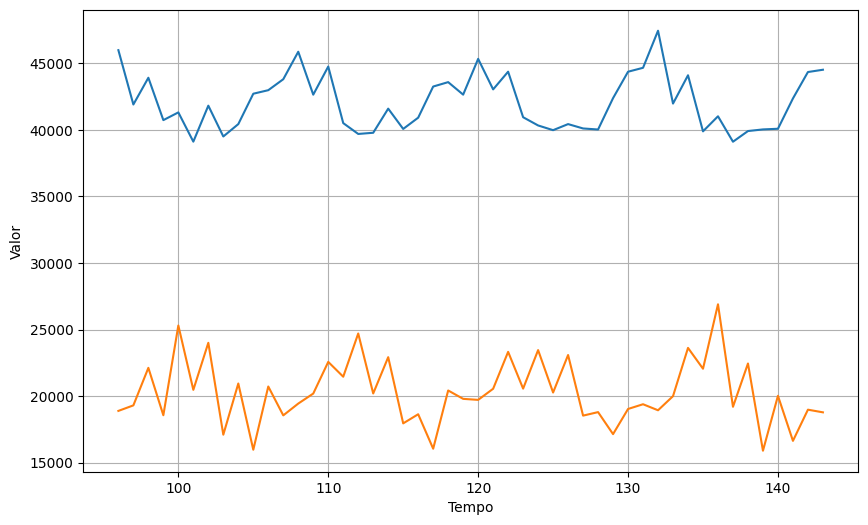

In [18]:
# Imprimir as formas após conversão e squeeze
print(f'shape após converter para numpy array: {np.array(forecast_WEB_RN).shape}')
print(f'shape após squeeze: {np.array(forecast_WEB_RN).squeeze().shape}')

# Converter para formato esperado pela função plotar_series
previsao_WEB_RN = np.array(forecast_WEB_RN).squeeze()

# Plotar as séries de validação e de previsão
plotar_series(tempo_valid_WEB_RN, (x_valid_WEB_RN, previsao_WEB_RN))

## Calcular  e imprimir métricas

In [19]:
# Calcula métricas de previsão
metricas_WEB_RN = metricas(previsao_WEB_RN, x_valid_WEB_RN)

print('Metricas Modelo WEB_RN')
for metrica in metricas_WEB_RN:
    print(f'{metrica} = {metricas_WEB_RN[metrica]}')

Metricas Modelo WEB_RN
ME = -21799.08168472005
MSE = 486702963.00359726
RMSE = 22061.345448625685
MAE = 21799.08168472005
MPE = -0.5165053313126061
MAPE = 0.5165053313126061
MIN-MAX = 0.516505331312606


# Comparar desempenho de modelos
* Série: WEB
* Modelos: Baseline, AUTOARIMA, GB e RN

### Calcular array com métricas do modelo WEB_RN

In [20]:
# Calcular array com métricas AUTOARIMA
metricas_WEB_RN = metricas(previsao_WEB_RN, x_valid_WEB_RN)

# Imprimir métricas de previsão
METRICAS = []
VALORES_WEB_RN = []
print('Metricas Modelo WEB RN')
for metrica in metricas_WEB_RN:
    print(f'{metrica} = {metricas_WEB_RN[metrica]}')
    METRICAS.append(metrica)
    VALORES_WEB_RN.append(metricas_WEB_RN[metrica])

Metricas Modelo WEB RN
ME = -21799.08168472005
MSE = 486702963.00359726
RMSE = 22061.345448625685
MAE = 21799.08168472005
MPE = -0.5165053313126061
MAPE = 0.5165053313126061
MIN-MAX = 0.516505331312606


### Salvar méticas para comparação

In [21]:
dfMetricas = pd.read_csv('/content/Métricas_Previsão.csv', index_col=0)
dfMetricas = dfMetricas.assign(WEB_RN=VALORES_WEB_RN)
print(dfMetricas)
dfMetricas.to_csv('/content/Métricas_Previsão.csv')

         ST_Baseline  WEB_Baseline   BD_Baseline  ST_AUTOARIMA  BD_AUTOARIMA  \
ME         -0.175799 -7.450912e+01 -3.879495e+02     49.857660 -1.347929e+03   
MSE       172.614151  4.322896e+06  6.146474e+06   7831.582677  5.482356e+06   
RMSE       13.138270  2.079158e+03  2.479208e+03     88.496230  2.341443e+03   
MAE        10.363013  1.653027e+03  1.862858e+03     71.980169  1.694711e+03   
MPE         0.004776 -5.410408e-04  5.406480e-03      0.014344 -1.300227e-01   
MAPE        0.086862  3.921937e-02  2.499672e-01      0.020229  2.059837e-01   
MIN-MAX     0.081098  3.780842e-02  2.116844e-01      0.019672  1.985067e-01   

         WEB_AUTOARIMA          ST_GB        WEB_GB         BD_GB      ST_RN  \
ME       -4.533259e+03    -255.863571  4.217371e+02 -4.634744e+03  -0.994816   
MSE       2.178596e+07  367645.818074  1.059666e+06  2.692134e+07  58.959614   
RMSE      4.667544e+03     606.338039  1.029401e+03  5.188578e+03   7.678516   
MAE       4.533259e+03     466.513514  

### Comparar desempenho dos modelos

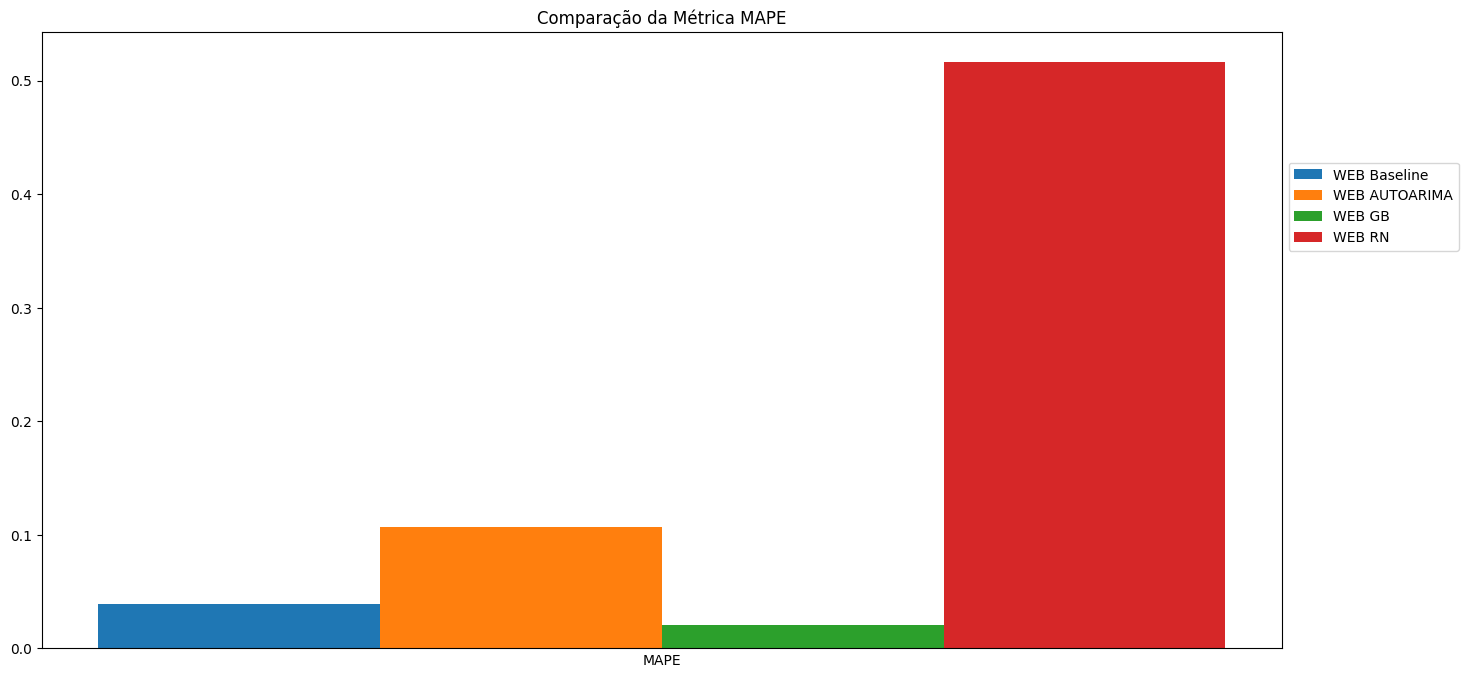

In [22]:
mWEB_Baseline = []
mWEB_Baseline.append(dfMetricas['WEB_Baseline'].loc['MAPE'])
mWEB_AUTOARIMA = []
mWEB_AUTOARIMA.append(dfMetricas['WEB_AUTOARIMA'].loc['MAPE'])
mWEB_GB = []
mWEB_GB.append(dfMetricas['WEB_GB'].loc['MAPE'])
mWEB_RN = []
mWEB_RN.append(dfMetricas['WEB_RN'].loc['MAPE'])

plt.bar(-0.6, mWEB_Baseline, 0.4, label = 'WEB Baseline')
plt.bar(-0.2, mWEB_AUTOARIMA, 0.4, label = 'WEB AUTOARIMA')
plt.bar(0.2, mWEB_GB, 0.4, label = 'WEB GB')
plt.bar(0.6, mWEB_RN, 0.4, label = 'WEB RN')

plt.xlabel('MAPE')
plt.xticks([])
plt.title('Comparação da Métrica MAPE')
plt.legend(bbox_to_anchor=(1, 0.8))
plt.show;

# Série de requisições mensais ao servidor BD

In [23]:
# Seleciona coluna WEB e reformata para requisições mensais (soma)
mensal = serie_requisicoes_dia['BD'].resample('M').sum()

# Selecionar dados a partir de Janeiro de 2010
mensal = pd.Series(mensal.loc['2010-01':'2017-12'], copy=True)

# Formatação com idex = data e coluna = Valor
serie_BD = pd.DataFrame(mensal.values, mensal.index, columns=['Valor'])
serie_BD.head(10)

<ipython-input-23-a35598ab3003>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  mensal = serie_requisicoes_dia['BD'].resample('M').sum()


,Valor
Data,
2010-01-31,3148.914
2010-02-28,3398.549
2010-03-31,4295.821
2010-04-30,2902.002
2010-05-31,2502.340
2010-06-30,1738.655
2010-07-31,1581.406
2010-08-31,2390.503
2010-09-30,2845.981


## Criar o dataset

In [24]:
# Criar o dataset
serie_BD_RN = serie_BD['Valor'].values
print(type(serie_BD_RN))
print(len(serie_BD_RN))
tempo_BD_RN = np.arange(len(serie_BD_RN), dtype="float32")
print(type(tempo_BD_RN))
print(len(tempo_BD_RN))

<class 'numpy.ndarray'>
96
<class 'numpy.ndarray'>
96


## Dividir os dados
* Dividir os dados em conjunto de treinamento e conjunto de validação
* Primeiros 2/3 dos pontos para treinamento e o restante é para validação

In [25]:
# Definir o tamanho do conjunto de treinamento
tam_trein_BD_RN = int(2/3*len(serie_BD_RN))

# Conjunto de treinamento
tempo_trein_BD_RN = tempo_BD_RN[:tam_trein_BD_RN]
x_trein_BD_RN = serie_BD_RN[:tam_trein_BD_RN]

# Conjunto de validação
tempo_valid_BD_RN = tempo_BD_RN[tam_trein_BD_RN:]
x_valid_BD_RN = serie_BD_RN[tam_trein_BD_RN:]

## Plotar série de treinamento

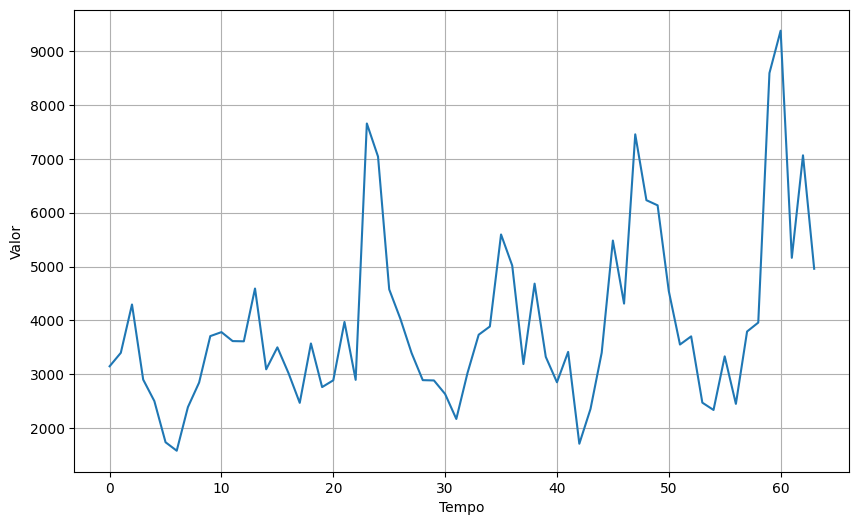

In [26]:
# Plotar série de treinamento
plotar_series(tempo_trein_BD_RN, x_trein_BD_RN)

## Plotar série de validação

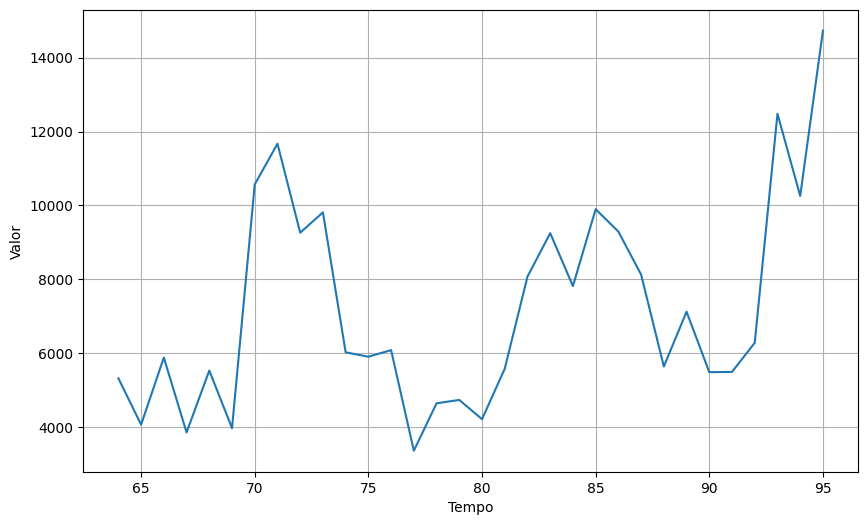

In [27]:
# Plotar série de validação
plotar_series(tempo_valid_BD_RN, x_valid_BD_RN)

# Modelo - BD RN
### Rede neural sequencial com 1 camada densa

## Preparar dataset para treinamento

### Parâmetros

In [28]:
# Parameteros
tam_janela_BD_RN = 7
tam_lote_BD_RN = 128
tam_buffer_embaralhamento_BD_RN = 10

### Criar dataset de treinamento

In [29]:
# Criar dataset de treinamento
dataset_BD_RN = janelamento_lotes(
    x_trein_BD_RN, tam_janela_BD_RN, tam_lote_BD_RN, tam_buffer_embaralhamento_BD_RN)

## Construir o modelo

In [30]:
# Construir o modelo
# Rede neural sequencial com 1 camada densa
c0 = tf.keras.layers.Dense(1, input_shape=[tam_janela_BD_RN])
modelo_BD_RN = tf.keras.models.Sequential([c0])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compilar o modelo
Prâmetros de treinamento:
* Função de perda (loss function): [*mean squared error (mse)*](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError).
* Algoritmo de otimização:  [*Adam algorithm*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam).

In [31]:
# Compilar o modelo
modelo_BD_RN.compile(loss="mse", optimizer=tf.keras.optimizers.Adam())

### Treinar o modelo

In [32]:
# Treinar o modelo
resultado_treinamento_BD_RN = modelo_BD_RN.fit(dataset_BD_RN,epochs=400, verbose = 0);

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


### Plotar perda em função da taxa de aprendizagem

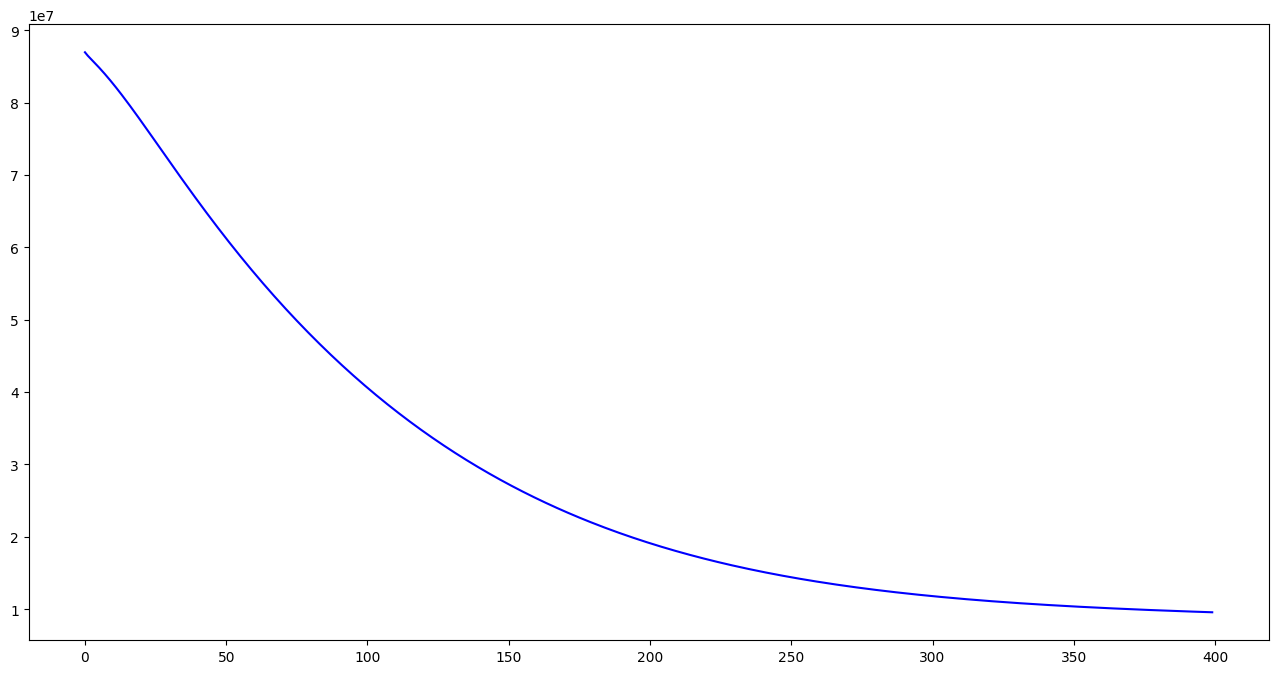

In [33]:
# Plotar perda em função da taxa de aprendizagem
perdas_BD_RN = resultado_treinamento_BD_RN.history['loss']
epocas_BD_RN = range(len(perdas_BD_RN))
plt.plot(epocas_BD_RN, perdas_BD_RN, 'b')
plt.show()

## Realizar previsões

In [34]:
# Inicializar a lista de previsões
forecast_BD_RN = []

# Selecionar pontos que estão alinhados com o conjunto de validação
serie_valid_BD_RN = serie_BD_RN[tam_trein_BD_RN - tam_janela_BD_RN:]

# Usar o modelo para prever um valor para cada janela
for indice in range(len(serie_valid_BD_RN) - tam_janela_BD_RN):
    forecast_BD_RN.append(
        modelo_BD_RN.predict(serie_valid_BD_RN[indice:indice + tam_janela_BD_RN][np.newaxis], verbose=0))

# Comparar a quantidade de elementos nos conjuntos de previsão e validação
print(f'tamanho da lista de previsão: {len(forecast_BD_RN)}')
print(f'shape do conjunto de validação: {x_valid_BD_RN.shape}')

tamanho da lista de previsão: 32
shape do conjunto de validação: (32,)


### Visualizar a previsão
* Converter a lista de previsões (`forecast`) para um array numpy de uma única dimensão (função squeeze).
* Forma esperada pela função `plotar_series()`.

shape após converter para numpy array: (32, 1, 1)
shape após squeeze: (32,)


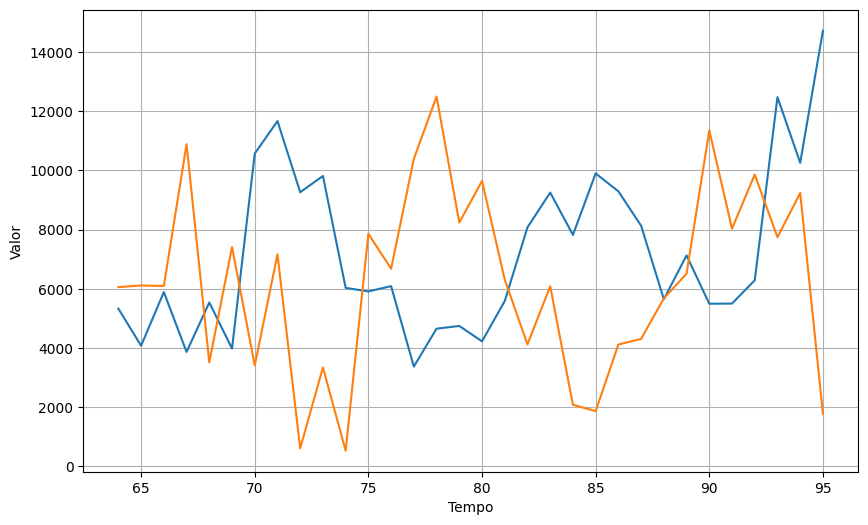

In [35]:
# Imprimir as formas após conversão e squeeze
print(f'shape após converter para numpy array: {np.array(forecast_BD_RN).shape}')
print(f'shape após squeeze: {np.array(forecast_BD_RN).squeeze().shape}')

# Converter para formato esperado pela função plotar_series
previsao_BD_RN = np.array(forecast_BD_RN).squeeze()

# Plotar as séries de validação e de previsão
plotar_series(tempo_valid_BD_RN, (x_valid_BD_RN, previsao_BD_RN))

## Calcular  e imprimir métricas

In [36]:
# Calcula métricas de previsão
metricas_BD_RN = metricas(previsao_BD_RN, x_valid_BD_RN)

print('Metricas Modelo BD_RN')
for metrica in metricas_BD_RN:
    print(f'{metrica} = {metricas_BD_RN[metrica]}')

Metricas Modelo BD_RN
ME = -972.2502220153809
MSE = 26750179.073647812
RMSE = 5172.057528068284
MAE = 4251.58456185913
MPE = 0.09413684015577393
MAPE = 0.6434847889238325
MIN-MAX = 0.4476417002965787


# Comparar desempenho de modelos
* Série: BD
* Modelos: Baseline, AUTOARIMA, GB e RN

### Calcular array com métricas do modelo BD_RN

In [37]:
# Calcular array com métricas AUTOARIMA
metricas_BD_RN = metricas(previsao_BD_RN, x_valid_BD_RN)

# Imprimir métricas de previsão
METRICAS = []
VALORES_BD_RN = []
print('Metricas Modelo BD RN')
for metrica in metricas_BD_RN:
    print(f'{metrica} = {metricas_BD_RN[metrica]}')
    METRICAS.append(metrica)
    VALORES_BD_RN.append(metricas_BD_RN[metrica])

Metricas Modelo BD RN
ME = -972.2502220153809
MSE = 26750179.073647812
RMSE = 5172.057528068284
MAE = 4251.58456185913
MPE = 0.09413684015577393
MAPE = 0.6434847889238325
MIN-MAX = 0.4476417002965787


### Salvar méticas para comparação

In [38]:
dfMetricas = pd.read_csv('/content/Métricas_Previsão.csv', index_col=0)
dfMetricas = dfMetricas.assign(BD_RN=VALORES_BD_RN)
print(dfMetricas)
dfMetricas.to_csv('/content/Métricas_Previsão.csv')

         ST_Baseline  WEB_Baseline   BD_Baseline  ST_AUTOARIMA  BD_AUTOARIMA  \
ME         -0.175799 -7.450912e+01 -3.879495e+02     49.857660 -1.347929e+03   
MSE       172.614151  4.322896e+06  6.146474e+06   7831.582677  5.482356e+06   
RMSE       13.138270  2.079158e+03  2.479208e+03     88.496230  2.341443e+03   
MAE        10.363013  1.653027e+03  1.862858e+03     71.980169  1.694711e+03   
MPE         0.004776 -5.410408e-04  5.406480e-03      0.014344 -1.300227e-01   
MAPE        0.086862  3.921937e-02  2.499672e-01      0.020229  2.059837e-01   
MIN-MAX     0.081098  3.780842e-02  2.116844e-01      0.019672  1.985067e-01   

         WEB_AUTOARIMA          ST_GB        WEB_GB         BD_GB      ST_RN  \
ME       -4.533259e+03    -255.863571  4.217371e+02 -4.634744e+03  -0.994816   
MSE       2.178596e+07  367645.818074  1.059666e+06  2.692134e+07  58.959614   
RMSE      4.667544e+03     606.338039  1.029401e+03  5.188578e+03   7.678516   
MAE       4.533259e+03     466.513514  

# FORMATIVA
### Comparar desempenho dos modelos

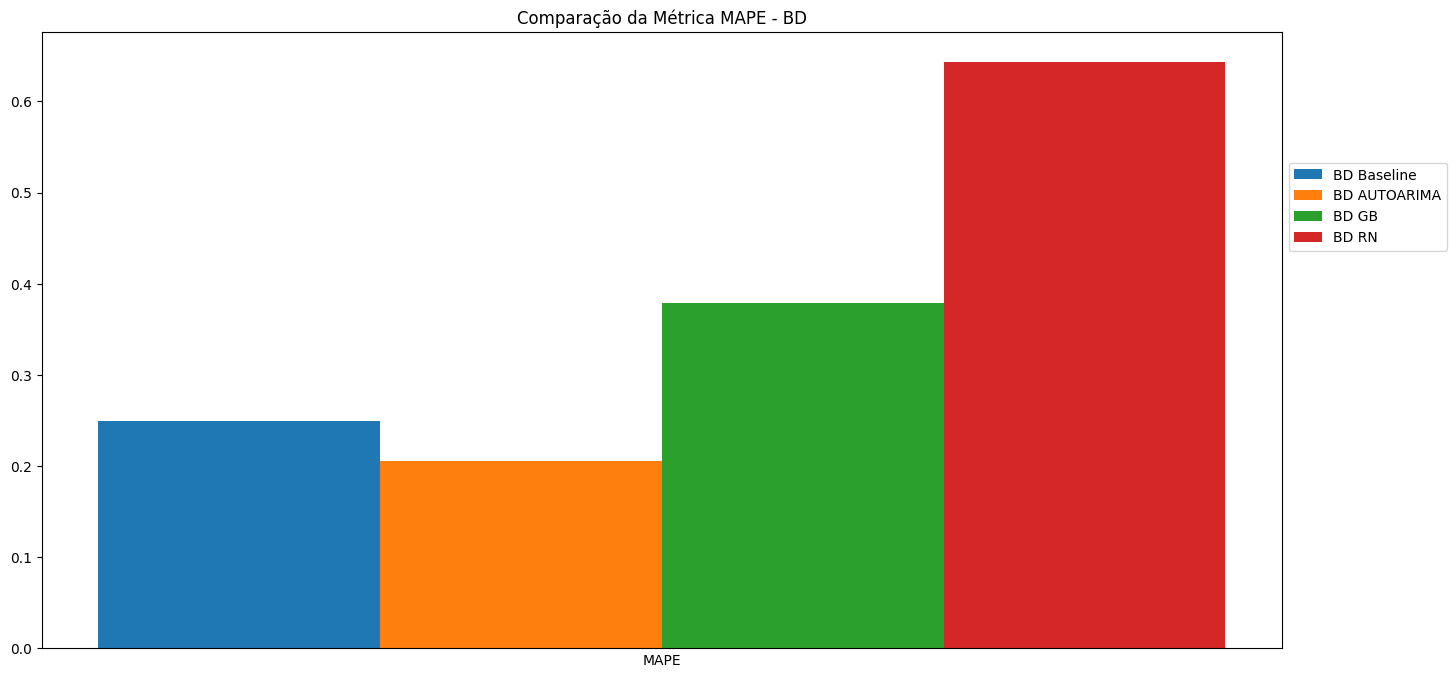

In [39]:
# PLOTAR GRÁFICO DE BARRAS COM MAPE
# SÉRIE BD -  MODELOS BASELINE AUTOARIMA GB E RN

mBD_Baseline = []
mBD_Baseline.append(dfMetricas['BD_Baseline'].loc['MAPE'])
mBD_AUTOARIMA = []
mBD_AUTOARIMA.append(dfMetricas['BD_AUTOARIMA'].loc['MAPE'])
mBD_GB = []
mBD_GB.append(dfMetricas['BD_GB'].loc['MAPE'])
mBD_RN = []
mBD_RN.append(dfMetricas['BD_RN'].loc['MAPE'])

plt.bar(-0.6, mBD_Baseline, 0.4, label = 'BD Baseline')
plt.bar(-0.2, mBD_AUTOARIMA, 0.4, label = 'BD AUTOARIMA')
plt.bar(0.2, mBD_GB, 0.4, label = 'BD GB')
plt.bar(0.6, mBD_RN, 0.4, label = 'BD RN')

plt.xlabel('MAPE')
plt.xticks([])
plt.title('Comparação da Métrica MAPE - BD')
plt.legend(bbox_to_anchor=(1, 0.8))
plt.show;

# Inserido para facilitar impressão 1

In [40]:
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#

# Inserido para facilitar impressão 2

In [41]:
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#

# Inserido para facilitar impressão 3

In [42]:
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#

# Inserido para facilitar impressão 4

In [43]:
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#